# Array expression profiling

**Summary**

NOTCH proteins regulate signaling pathways involved in cellular differentiation, proliferation and death. 
Overactive Notch signaling as been observed in numerous cancers and has been extensively studied in the context of T-cell acute lymphoblastic leukemia (T-ALL) where more than 50% of pateints harbour mutant NOTCH1.
Small molecule modulators of these proteins would be important for understanding the role of NOTCH proteins in malignant and normal biological processes.

We were interested to measure the global changes in gene expression upon treatment of the human T-ALL cell lines HPB-ALL and KOPT-K1 with either vehicle alone (DMSO) or SAHM1, an alpha-helical hydrocarbon stapled peptide derived from the MAML1 co-activator protein.
 	
**Overall design**
Triplicate cultures of KOPT-K1 or HPB-ALL cells were treated with either DMSO alone or SAHM1 (20 uM) for 24 hours. Total RNA was extracted and hybridized to Affymetrix human U133 plus 2.0 microarrays (three arrays per treatment per cell line for a total of 12 arrays).

## Pipeline

## Python imports

In [5]:
import rpy2.rinterface
%reload_ext rpy2.ipython

## R imports

In [93]:
%%R
##1. Load libraries
library("affy")
library("limma")
library("genefilter")
library(hgu133plus2.db)
wd <- "/Users/nandoide/misc_work/Desktop/uni/TRREP"
setwd(wd)

## Functions

In [213]:
%%R

import_CEL <- function(pattern) {
    # Import CEL files into affiBatch object
    files <- list.files(pattern = pattern)
    names <- gsub(".CEL.gz", "", files)
    abatch <- ReadAffy(filenames = files,  compress = TRUE, sampleNames = names)
    return(abatch)
}

create_eset <- function(affyBatch) {
    # Generates object eset (class ExprSet), 
    # expresso function provides intensities in log scale
    return(expresso(affyBatch,
             bg.correct = TRUE, 
             bgcorrect.method="rma",
             normalize = TRUE, 
             normalize.method="quantiles", 
             pmcorrect.method="pmonly", 
             summary.method="medianpolish",
             verbose = TRUE))
}

boxplots <- function(affyBatch, eset, title) {
    # Generate BOXPLOTS before and after normalization
    boxplot(affyBatch,
        main=paste0("Boxplot Before Normalization ", title),
        col = "lightgrey")
    df_eset <- as.data.frame(exprs(eset))
    
    boxplot(data.frame(df_eset),
        main=paste0("Boxplot After Normalization (log scale) ", title), col = "white")
}

create_TopTable <- function(eset, control_samples=c(1,1,1,0,0,0)) {
    # Generate Toptable with limma 
    
    # Data filtering using IQR.
    esetIQR <- varFilter(eset, var.func=IQR, var.cutoff=0.5, filterByQuantile=TRUE)

    # Differential expression analysis.#######
    r_control_samples <- 1 - control_samples
    design <- cbind(DMSO=control_samples, SAHM1=r_control_samples)

    rownames(design) <- colnames(eset)

    #7. Contrasts matrix.
    cont.matrix <- makeContrasts(DMSO_SAHM1 = SAHM1 - DMSO, levels = design)

    #8. Obtaining differentially expressed genes (DEGs)
    #Linear model and eBayes 
    fit <- lmFit(esetIQR, design)  ##getting DEGs from IQR 
    fit2 <- contrasts.fit(fit, cont.matrix)
    fit2 <- eBayes(fit2)

    #Table with DEGs results
    toptableIQR <- topTable(fit2, number=dim(exprs(esetIQR))[1], adjust.method="BH", sort.by="p")
    return(toptableIQR)
}

anotate_TopTable <- function(toptable) {
    # Obtain gene names from probe names and chip symbol dataset
    probenames_toptable <- as.character(rownames(toptable ))
    genesymbols_toptable <- as.character(mget(probenames_toptable, hgu133plus2SYMBOL))
    # Annotated gene table
    toptable_anot <- cbind(Symbol = genesymbols_toptable, toptable)
    return(toptable_anot)
}

generank_table <- function(toptable, rnk.file) {
    # Generate rank of table top 50 upregulared and top 50 downregulated from 250 better
    # adjustes p-values
    more_significant = toptable[order(toptable$adj.P.Val, decreasing = FALSE),][1:250,]
    up_50 = more_significant[which(toptable$logFC > 0), ] [1:50,] # up reg top 50
    down_50 = more_significant[which(toptable$logFC < 0), ] [1:50,] # down reg top 50

    print("Down-regulated genes")
    print(down_50[order(down_50$logFC), c(1,2,5)])

    print("Up-regulated genes")
    print(up_50[order(up_50$logFC), c(1,2,5)])

    d <- rbind(down_50[order(down_50$logFC), c(1,2,5)], up_50[order(up_50$logFC), c(1,2,5)])
   
    #df <- data.frame(paste0(d$Symbol, '|', row.names(d)), d$logFC)
    df <- data.frame(row.names(d), d$logFC)
    write.table(df,row.names=FALSE,col.names=FALSE,
                quote=FALSE,sep="\t",file=paste0(rnk.file, ".rnk"))
}

## Load raw data

In [158]:
%%R
setwd("GSE18198_data")
affyBatch_HPB = import_CEL("HPB*")
affyBatch_KOPT = import_CEL("KOPT*")
setwd(wd)

## Create expression sets

In [153]:
%%R
eset_HPB <- create_eset(affyBatch_HPB)
eset_KOPT <- create_eset(affyBatch_KOPT)

background correction: rma 
normalization: quantiles 
PM/MM correction : pmonly 
expression values: medianpolish 
background correcting...done.
normalizing...done.
54675 ids to be processed
|                    |
|####################|
background correction: rma 
normalization: quantiles 
PM/MM correction : pmonly 
expression values: medianpolish 
background correcting...done.
normalizing...done.
54675 ids to be processed
|                    |
|####################|


In [156]:
%%R
save(eset_HPB, file="eset_HPB.RData")
save(eset_KOPT, file="eset_KOPT.RData")

## Quality plots

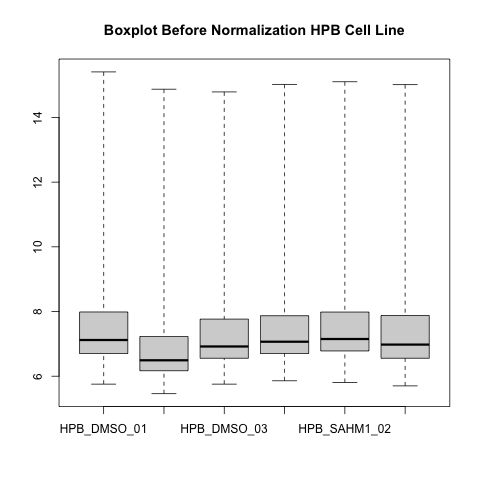

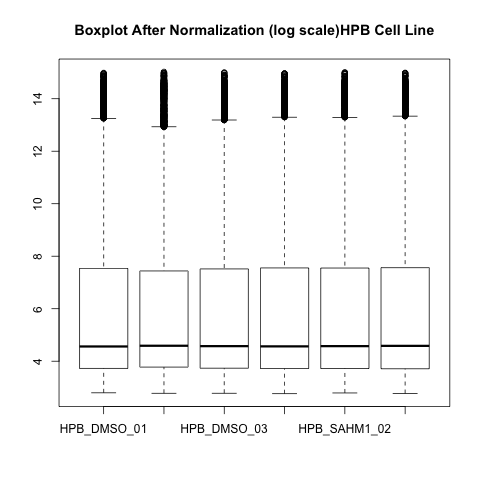

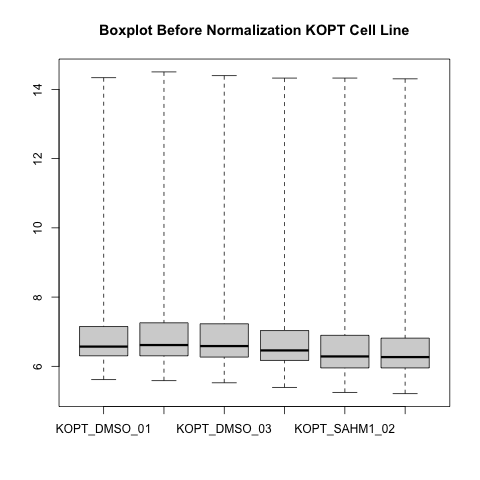

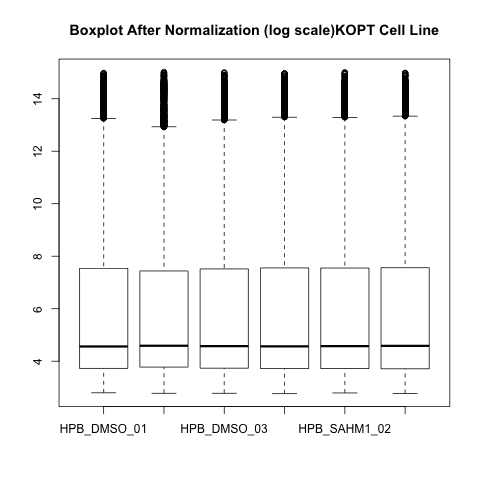

In [159]:
%%R
boxplots(affyBatch_HPB, eset, "HPB Cell Line")
boxplots(affyBatch_KOPT, eset, "KOPT Cell Line")

## Differential expressed genes

In [170]:
%%R
toptable_HPB <- create_TopTable(eset_HPB)
toptable_anot_HPB <- anotate_TopTable(toptable_HPB)
generank_table(toptable_anot_HPB, "generank_HPB")

[1] "Down-regulated genes"
               Symbol      logFC      P.Value
225342_at         AK4 -2.1078858 2.477920e-09
230710_at    MIR210HG -1.9761492 1.124964e-09
227336_at        DTX1 -1.3841443 4.106969e-08
201842_s_at    EFEMP1 -1.3678548 2.196591e-08
204348_s_at       AK4 -1.3491612 3.922276e-07
227347_x_at      HES4 -1.2640712 6.910681e-08
200953_s_at     CCND2 -1.2357909 3.510442e-08
202464_s_at    PFKFB3 -1.1937490 7.190421e-08
202022_at       ALDOC -1.1753644 7.989863e-08
240546_at   LINC01120 -1.1131135 1.103841e-07
227337_at     ANKRD37 -1.1079168 2.161918e-07
200894_s_at     FKBP4 -1.0737202 7.367763e-07
217078_s_at    CD300A -1.0719092 1.507092e-06
201170_s_at   BHLHE40 -1.0402130 2.797321e-07
202934_at         HK2 -1.0377714 2.058505e-07
201848_s_at     BNIP3 -1.0052154 1.108152e-06
218051_s_at    NT5DC2 -1.0049990 1.010083e-05
203394_s_at      HES1 -0.9993973 1.254181e-06
219371_s_at      KLF2 -0.9800918 4.873149e-07
201251_at         PKM -0.9787897 2.113749e-05
201849_

In [171]:
%%R
toptable_KOPT <- create_TopTable(eset_KOPT)
toptable_anot_KOPT <- anotate_TopTable(toptable_KOPT)
generank_table(toptable_anot_KOPT, "generank_KOPT")

[1] "Down-regulated genes"
               Symbol     logFC      P.Value
209921_at     SLC7A11 -2.916468 1.310423e-15
205047_s_at      ASNS -2.757747 3.034026e-15
209369_at       ANXA3 -2.661459 1.511951e-15
219270_at       CHAC1 -2.264373 2.401463e-13
226517_at       BCAT1 -2.216157 5.303756e-14
214452_at       BCAT1 -2.166267 1.742595e-12
225285_at       BCAT1 -2.072317 3.848602e-14
217678_at     SLC7A11 -2.058710 2.464934e-13
230748_at     SLC16A6 -2.004791 4.677510e-12
219892_at      TM6SF1 -1.957664 3.702055e-13
220892_s_at     PSAT1 -1.938100 9.078716e-14
204351_at       S100P -1.902944 3.879042e-12
223195_s_at     SESN2 -1.889417 2.491927e-13
214079_at       DHRS2 -1.873374 3.900855e-12
209822_s_at     VLDLR -1.863734 2.466589e-12
212290_at      SLC7A1 -1.860735 2.853913e-11
202847_at        PCK2 -1.828534 5.310992e-13
225520_at          NA -1.790127 4.616209e-13
223062_s_at     PSAT1 -1.786577 5.539870e-13
223196_s_at     SESN2 -1.730910 4.054436e-11
200924_s_at    SLC3A2 -1.698

## Generate GSEA gct, cls files

In [192]:
%%R

write.table(exprs(eset_HPB),row.names=TRUE,col.names=FALSE,quote=FALSE,file="eset_HPB.tsv", sep = "\t")
write.table(exprs(eset_KOPT),row.names=TRUE,col.names=FALSE,quote=FALSE,file="eset_KOPT.tsv", sep = "\t")

In [198]:
%%bash
echo "#1.2" > gct.head
echo "$(cat eset_HPB.tsv | wc -l) 6" >> gct.head
echo "GID	NAME	HPB_DMSO_01	HPB_DMSO_02	HPB_DMSO_03	HPB_SAHM1_01	HPB_SAHM1_02	HPB_SAHM1_03" >> gct.head
#head gct.head
cat gct.head eset_HPB.tsv > eset_HPB.gct
cat gct.head eset_KOPT.tsv > eset_KOPT.gct
head eset_KOPT.gct

echo "6	2	1" > phenotypes.cls
echo "# DMSO SAHM1" >> phenotypes.cls
echo "0	0	0	1	1	1" >> phenotypes.cls
cat phenotypes.cls

#1.2
   54675 6
GID	NAME	HPB_DMSO_01	HPB_DMSO_02	HPB_DMSO_03	HPB_SAHM1_01	HPB_SAHM1_02	HPB_SAHM1_03
1007_s_at	6.39550778914434	6.63361329719407	6.6375785381641	7.00665069446903	6.68384761746578	6.81043796741411
1053_at	8.27291684544428	8.04195281624978	8.13203974449545	8.07153608599753	7.85863717382127	8.02719895633383
117_at	3.14729311345973	2.94262593114145	3.15131758375372	3.05034281709199	3.23612638945269	3.14794105723779
121_at	6.87870865041484	6.88129495627018	6.82820532797191	6.86631576689715	6.95693356773948	6.83081218004268
1255_g_at	2.81967249987976	2.88648735903777	2.88201717529506	2.97379457130539	2.98461193851988	3.01905325883313
1294_at	6.87006027265826	6.80399928959987	6.65695733746297	6.57214844234865	6.65606153751673	6.80098950326962
1316_at	3.77034812760452	3.82602264159359	4.09195191846965	3.72596001077624	4.2350082264062	4.00773283062547
6	2	1
# DMSO SAHM1
0	0	0	1	1	1


## GSEA results

![Notch Signaling](images/enplot_HALLMARK_NOTCH_SIGNALING_625.jpg "Notch signalling pathway" )

## Processing all samples

In [214]:
%%R
setwd("GSE18198_data")
affyBatch = import_CEL("*")
setwd(wd)
eset <- create_eset(affyBatch)
toptable <- create_TopTable(eset, control_samples=c(1,1,1,0,0,0,1,1,1,0,0,0))
toptable_anot <- anotate_TopTable(toptable)
generank_table(toptable_anot, "generank")
save(eset, file="eset.RData")
# Create files for GSEA
write.table(exprs(eset),row.names=TRUE,col.names=FALSE,quote=FALSE,file="eset.tsv", sep = "\t")

background correction: rma 
normalization: quantiles 
PM/MM correction : pmonly 
expression values: medianpolish 
background correcting...done.
normalizing...done.
54675 ids to be processed
|                    |
|####################|
[1] "Down-regulated genes"
               Symbol      logFC      P.Value
227347_x_at      HES4 -1.2391846 4.541483e-05
227336_at        DTX1 -1.0787341 1.772044e-03
230263_s_at     DOCK5 -1.0589452 2.174812e-04
218051_s_at    NT5DC2 -0.9507155 1.126824e-03
205544_s_at       CR2 -0.9438572 5.961088e-05
202464_s_at    PFKFB3 -0.9408542 1.077045e-04
226452_at        PDK1 -0.8325181 2.019305e-05
223364_s_at     DHX37 -0.8207408 1.605856e-03
206686_at        PDK1 -0.8172945 9.936732e-04
203627_at       IGF1R -0.8050123 1.277490e-03
203867_s_at      NLE1 -0.7963720 7.746991e-04
204513_s_at     ELMO1 -0.7885410 1.839908e-04
207543_s_at     P4HA1 -0.7663495 3.287902e-05
212063_at        CD44 -0.7621344 1.769410e-03
227337_at     ANKRD37 -0.7620441 3.022164e-04
2

In [215]:
%%bash
echo "#1.2" > gct.head
echo "$(cat eset.tsv | wc -l) 12" >> gct.head
echo "GID	NAME	HPB_DMSO_01	HPB_DMSO_02	HPB_DMSO_03	HPB_SAHM1_01	HPB_SAHM1_02	HPB_SAHM1_03	KOPT_DMSO_01	KOPT_DMSO_02	KOPT_DMSO_03	KOPT_SAHM1_01	KOPT_SAHM1_02	KOPT_SAHM1_03" >> gct.head
#head gct.head
cat gct.head eset.tsv > eset.gct
head eset.gct

echo "12	2	1" > phenotypes_all.cls
echo "# DMSO SAHM1" >> phenotypes_all.cls
echo "0	0	0	1	1	1	0	0	0	1	1	1" >> phenotypes_all.cls
cat phenotypes_all.cls

#1.2
   54675 12
GID	NAME	HPB_DMSO_01	HPB_DMSO_02	HPB_DMSO_03	HPB_SAHM1_01	HPB_SAHM1_02	HPB_SAHM1_03	KOPT_DMSO_01	KOPT_DMSO_02	KOPT_DMSO_03	KOPT_SAHM1_01	KOPT_SAHM1_02	KOPT_SAHM1_03
1007_s_at	7.93312670379653	8.0542010037019	7.95037177526279	8.14888412184819	8.07040224126479	8.13284175160718	7.85405862605073	7.93163674386994	7.98141396242764	8.23905406061932	7.67867201107947	7.99642963218746
1053_at	9.27929486368929	9.09842264841232	9.13663090431202	9.17708364564691	9.25193771745009	9.25935418937713	9.19791748340989	9.01830505039165	9.10266422012541	9.00617077213224	8.847158491907	8.96969656837736
117_at	3.57098005665705	3.72380927817243	3.74780750590507	3.43028679172995	3.58735116951185	3.67221660949905	3.73807320168918	3.56701089801695	3.83082492669122	3.64438471116145	3.73805379638288	3.76775757547126
121_at	6.63358355634922	7.03665979693398	6.56807516112594	6.67607356294671	6.64106588645408	6.66741769078119	7.80465328459714	7.84417420209367	7.78011537263602	7.82982021440325	7.98585

## Conclusions

# Outputs

In [217]:
%%bash
jupyter nbconvert --to=latex --template=~/report.tplx TRREP_final.ipynb
/Library/TeX/texbin/pdflatex -shell-escape TRREP_final
#jupyter nbconvert --to html_with_toclenvs TRREP_final.ipynb 1> /dev/null

This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=pdflatex)
 \write18 enabled.
entering extended mode
(./TRREP_final.tex
LaTeX2e <2018-04-01> patch level 2
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/size11.clo))
(/usr/local/texlive/2018/texmf-dist/tex/latex/placeins/placeins.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2018/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/

[NbConvertApp] Converting notebook TRREP_final.ipynb to latex
/Users/nandoide/miniconda3/lib/python3.7/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.2.3.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
/Users/nandoide/miniconda3/lib/python3.7/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.2.3.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
/Users/nandoide/miniconda3/lib/python3.7/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.2.3.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_

CalledProcessError: Command 'b'jupyter nbconvert --to=latex --template=~/report.tplx TRREP_final.ipynb\n/Library/TeX/texbin/pdflatex -shell-escape TRREP_final\n#jupyter nbconvert --to html_with_toclenvs TRREP_final.ipynb 1> /dev/null\n'' returned non-zero exit status 1.